In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML/icml_face_data.csv')

In [ ]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [9]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [10]:
images, labels = parse_data(df)

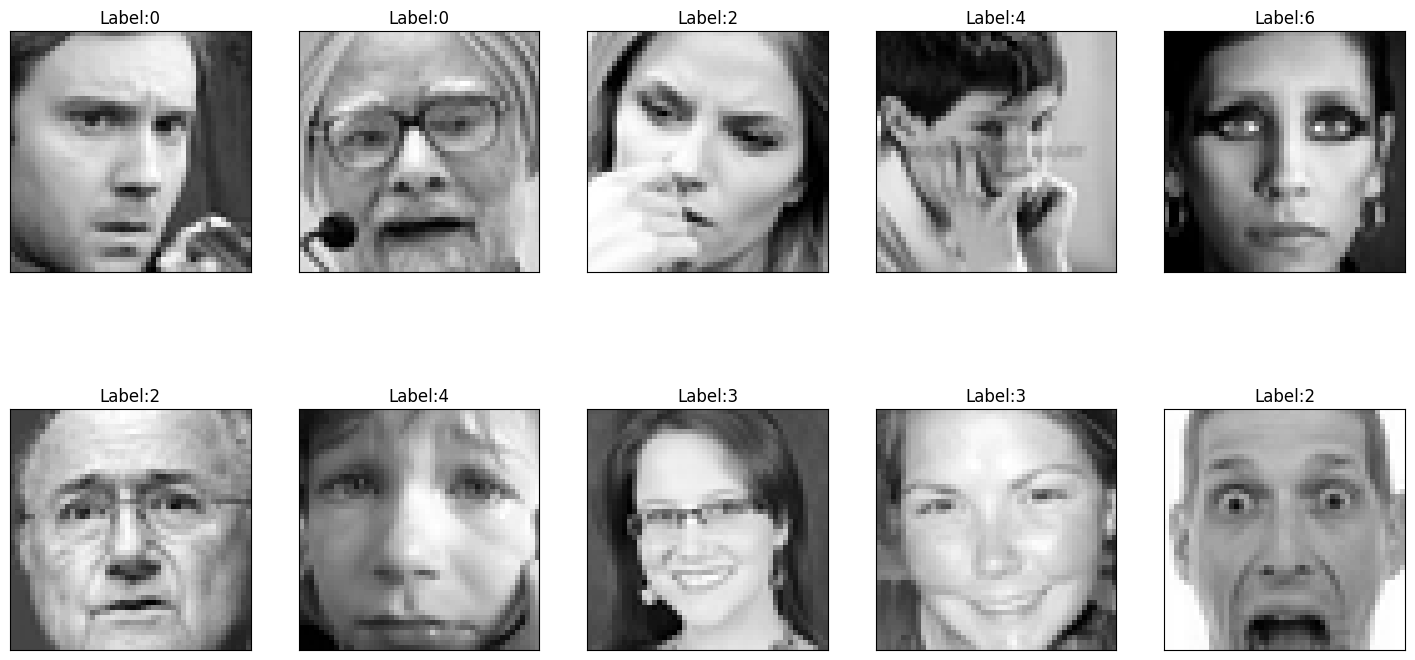

In [11]:
show_img(images, labels)

In [5]:
# Convert the pixels column from strings to lists of integers
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype=int))

# Determine the maximum length of pixel arrays
max_length = df['pixels'].apply(len).max()

# Pad or trim each array to the maximum length
df['pixels'] = df['pixels'].apply(lambda x: np.pad(x, (0, max_length - len(x)), 'constant') if len(x) < max_length else x[:max_length])

# Stack pixel data into a 2D array for PCA
pixel_data = np.stack(df['pixels'].values)

In [ ]:
pixel_data

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 17,  17,  16, ..., 154, 133, 113],
       [ 30,  28,  28, ...,  35,  30,  28],
       [ 19,  13,  14, ..., 189, 199, 201]])

In [ ]:
pixel_data.shape

(35887, 2304)

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
# pca.fit(images) ## modify images' array to the appropriate shape
pca.fit(pixel_data) ## modify images' array to the appropriate shape

PCA(n_components=2)

In [ ]:
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
images_pca=pca.transform(pixel_data) ## modify images' array to the appropriate shape

images_pca.shape

(35887, 2)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# # y = df['TARGET']
# scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

pca = PCA()
# pca_result = pca.fit_transform(pixel_data)
pca_result = pca.fit(pixel_data)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.95

n_components = np.argmax(explained_variance_ratio >= threshold) + 1
print(f"Number of components to explain {threshold * 100}% variance: {n_components}")

Number of components to explain 95.0% variance: 255


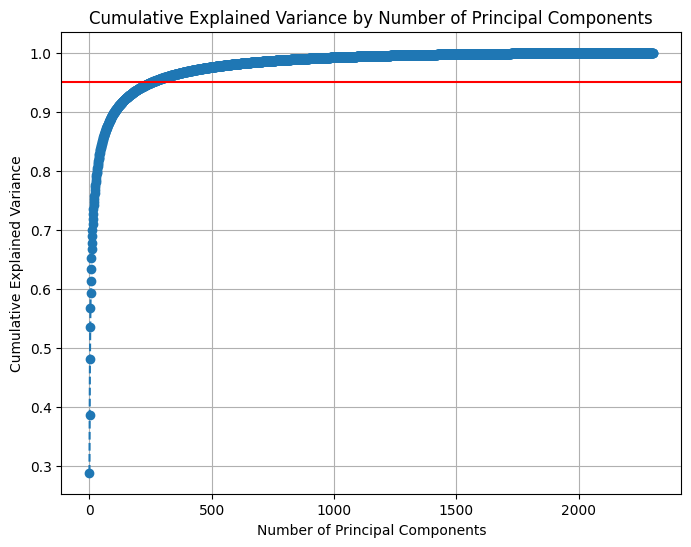

array([0.2892651 , 0.387289  , 0.48154432, ..., 0.99999913, 0.99999958,
       1.        ])

In [ ]:
import matplotlib.pyplot as plt

# Fit PCA with enough components to capture most of the variance
pca_full = PCA()
pca_full.fit(pixel_data)

# Calculate cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

# Print the cumulative explained variance
cumulative_explained_variance


# Original Dataset (before applying PCA)

In [6]:
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
X = pixel_data
y = df['emotion']

In [8]:
RANDOM_STATE = 12
TRAIN_SIZE = 0.7

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [ ]:
def build_SVCmodel(X, y, random_state=42):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svc", SVC(random_state=random_state)),
        ]
    )

    # Fit the pipeline on the training data
    pipeline.fit(X, y)

    return pipeline

# Example usage with training data (assuming X_train and y_train are defined)
pipeline = build_SVCmodel(X_train, y_train)

# Make predictions on the test data (assuming X_test is defined)
pred = pipeline.predict(X_test)

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'svc__C': [0.1, 1, 10],
#     'svc__kernel': ['rbf', 'poly'],
#     'svc__gamma': ['scale', 'auto'],
# }

# # Initialize GridSearchCV with your pipeline and parameter grid
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# # Fit GridSearchCV on your training data
# grid_search.fit(X_train, y_train)

# # Retrieve the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print("Best Parameters:", best_params)
# print("Best Model:", best_model)

[4 5 3 ... 3 3 4]


In [ ]:
print(classification_report(y_test,pred))

'              precision    recall  f1-score   support\n\n           0       0.45      0.24      0.32      1476\n           1       0.90      0.05      0.10       176\n           2       0.39      0.22      0.28      1519\n           3       0.49      0.74      0.59      2688\n           4       0.37      0.41      0.39      1872\n           5       0.62      0.56      0.59      1155\n           6       0.43      0.45      0.44      1881\n\n    accuracy                           0.46     10767\n   macro avg       0.52      0.38      0.39     10767\nweighted avg       0.46      0.46      0.44     10767\n'

In [ ]:
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test , pred, average = 'micro'))
print("Recall: ", recall_score(y_test , pred, average = 'micro'))
print("F1: ", f1_score(y_test , pred, average = 'micro'))

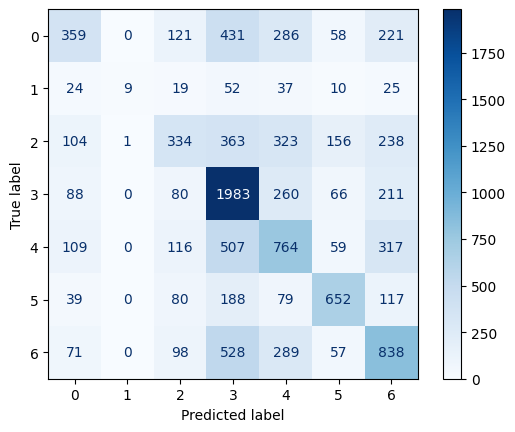

In [ ]:
cm = confusion_matrix(y_test, pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmd.plot(cmap='Blues')

In [15]:
# !pip install lazypredict

In [ ]:
# from lazypredict.Supervised import LazyClassifier
# clf = LazyClassifier(verbose=0, custom_metric=None)
# scores, predictions = clf.fit(X_train, X_test, y_train, y_test)
# display(scores)

In [9]:
from sklearn.naive_bayes import GaussianNB
def build_GaussianNBmodel(X, y, random_state=42):
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("gaussianNB", GaussianNB()),
        ]
    )

    # Fit the pipeline on the training data
    pipeline.fit(X, y)

    return pipeline

pipeline = build_GaussianNBmodel(X_train, y_train)
pred = pipeline.predict(X_test)

In [11]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.18      0.05      0.08      1476
           1       0.02      0.17      0.04       176
           2       0.22      0.05      0.08      1519
           3       0.38      0.17      0.24      2688
           4       0.26      0.41      0.32      1872
           5       0.20      0.59      0.30      1155
           6       0.27      0.18      0.21      1881

    accuracy                           0.23     10767
   macro avg       0.22      0.23      0.18     10767
weighted avg       0.27      0.23      0.21     10767



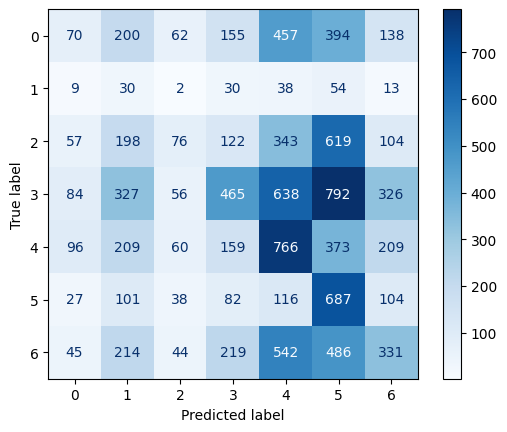

In [12]:
cm = confusion_matrix(y_test, pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmd.plot(cmap='Blues')

In [13]:
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test , pred, average = 'micro'))
print("Recall: ", recall_score(y_test , pred, average = 'micro'))
print("F1: ", f1_score(y_test , pred, average = 'micro'))

Accuracy:  0.22522522522522523
Precision:  0.22522522522522523
Recall:  0.22522522522522523
F1:  0.22522522522522523


In [17]:
from sklearn.linear_model import LogisticRegression
def build_Logisticmodel(X, y):
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("logisticRegression", LogisticRegression(solver='liblinear')),
        ]
    )

    # Fit the pipeline on the training data
    pipeline.fit(X, y)

    return pipeline

pipeline = build_Logisticmodel(X_train, y_train)
pred = pipeline.predict(X_test) #Chay mat 30'

In [18]:
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test , pred, average = 'macro'))
print("Recall: ", recall_score(y_test , pred, average = 'macro'))
print("F1: ", f1_score(y_test , pred, average = 'macro'))

Accuracy:  0.3350051082009845
Precision:  0.2917353341020645
Recall:  0.2966241306912539
F1:  0.29126101834635504


In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer

# f1 = make_scorer(f1_score , average='macro')
# model = LogisticRegression()
# solvers = ['newton-cg', 'liblinear']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]

# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=f1,error_score=0)
# grid_result = grid_search.fit(X_train, y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

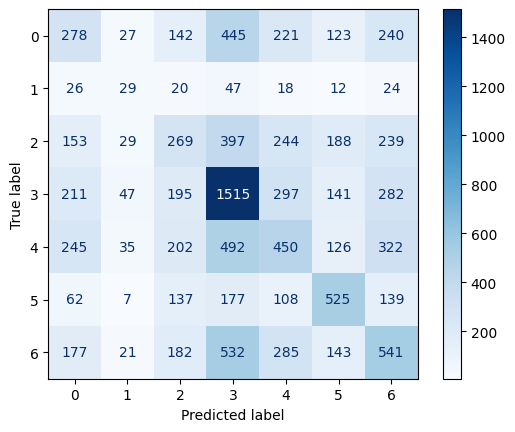

In [19]:
cm = confusion_matrix(y_test, pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmd.plot(cmap='Blues')